In [2]:
# Importing Packages
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Reading Files to fetch data
train_data=pd.read_csv("C:/Users/nitsc/OneDrive/Documents/Competitions/BA Showcase/train.csv")
train_data.head()
#pd.options.display.max_colwidth = 500

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [4]:
# Badwords function - using badword txt file
def loadBW():
    f = open('badwords.txt', "r")
    bwMap = dict()
    for line in f:
        sp = line.strip().lower().split(",")
        if len(sp) == 2:
            bwMap[sp[0].strip()] = sp[1].strip()
    return bwMap

In [5]:
# Normalizing the data - treatment of words
def normalize(f):
    f = [x.lower() for x in f]
    f = [x.replace("\\n"," ") for x in f]        
    f = [x.replace("\\t"," ") for x in f]        
    f = [x.replace("\\xa0"," ") for x in f]
    f = [x.replace("\\xc2"," ") for x in f]
    f = [x.replace(" u "," you ") for x in f]
    f = [x.replace(" em "," them ") for x in f]
    f = [x.replace(" da "," the ") for x in f]
    f = [x.replace(" yo "," you ") for x in f]
    f = [x.replace(" ur "," you ") for x in f]    
    f = [x.replace("won't", "will not") for x in f]
    f = [x.replace("can't", "cannot") for x in f]
    f = [x.replace("i'm", "i am") for x in f]
    f = [x.replace(" im ", " i am ") for x in f]
    f = [x.replace("ain't", "is not") for x in f]
    f = [x.replace("'ll", " will") for x in f]
    f = [x.replace("'t", " not") for x in f]
    f = [x.replace("'ve", " have") for x in f]
    f = [x.replace("'s", " is") for x in f]
    f = [x.replace("'re", " are") for x in f]
    f = [x.replace("'d", " would") for x in f]
    
    bwMap = loadBW()
    for key, value in bwMap.items():
        kpad = "" + key + ""
        vpad = " " + value + " "
        f = [x.replace(kpad, vpad) for x in f]
     
    return f

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nitsc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nitsc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Taking relevant stop words
stop_words=stopwords.words('english')
stop_words.remove('you')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd'

In [9]:
# Cleaning Function - Tokenization & Punctuation Removal, No Stemming 
def cleaning(x):
    train_data.columns
    tokenized_data=[]
    cleaned_data=[]
    for i in x:
        normalize(i)
        tokenized_data.append(nltk.word_tokenize(i.lower()))
    punct=[i for i in string.punctuation]
    noise=stop_words+punct+['``',"''"]   
    for i in tokenized_data:
        k=[j for j in i if j not in noise]
        cleaned_data.append(k)
    cleaned_data=[' '.join(x) for x in cleaned_data]
    return cleaned_data
#cleaning(train_data['Comment'])

In [10]:
# TF-IDF Vectorization
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words = 'english')
#X_train=cleaning(train_data['Comment'])
X_train=normalize(train_data['Comment'])
tfidf_matrix =  tf.fit_transform(X_train)
feature_names = tf.get_feature_names()

In [11]:
Y_train=train_data['Insult'].astype('int')
y=np.array(Y_train)

# Feature Selection
ch2 = SelectKBest(chi2, k=500*3)
X_train = ch2.fit_transform(tfidf_matrix,y)
ch2_features = [feature_names[i] for i in ch2.get_support(indices=True)]
X_train_dense=X_train.toarray()
#X_test = ch2.transform(X_test)

In [12]:
# Model
glm=linear_model.LogisticRegression(C=3)
glm.fit(X_train_dense, y)
pred = glm.predict_proba(X_train_dense) 
preds=pred[:,1]

In [13]:
# Assigning threshold
final_pred=[]
len(preds[preds>0.29])
for i in range(len(preds)):
    if preds[i]>=0.28:
        final_pred.append(1)
    else:
        final_pred.append(0)
#final_pred=np.asarray(final_pred)
#len(Y_train[Y_train==1])
#len(final_pred)

In [14]:
# Confusion Matrix to check classification distribution
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_train,final_pred)
confusion_matrix

array([[2641,  257],
       [  85,  964]], dtype=int64)

In [15]:
# array([[2618,  280],
#       [ 276,  773]], dtype=int64)

# array([[2654,  244],
#       [ 303,  746]], dtype=int64)

# array([[2618,  280],
#       [ 274,  775]], dtype=int64)
(2634+964)/(len(final_pred))

0.9115784139853053

## Validation - Using Test Data

In [16]:
# Loading test data
test_data=pd.read_csv('test_with_solutions1.csv')
X_test=normalize(test_data['Comment'])
Y_actual=test_data['Insult'].astype('int')

# Cleaning
#X_test=cleaning(X_test)

In [17]:
# Transformation 
X_test=tf.transform(X_test)

In [18]:
# Feature Selection
X_test=ch2.transform(X_test)
X_test_dense=X_test.toarray()

In [19]:
# Prediction
test_pred=glm.predict_proba(X_test_dense)

In [20]:
# Cut off
test_pred=test_pred[:,1]

In [21]:
final_test_pred=[]
for i in range(len(test_pred)):
    if test_pred[i]>=0.28:
        final_test_pred.append(1)
    else:
        final_test_pred.append(0)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(Y_actual,final_test_pred)
confusion_matrix1
(1682+463)/len(final_test_pred)

0.8103513411409142

In [23]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Y_actual, final_test_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [24]:
roc_auc

{0: 0.76603954444281974}

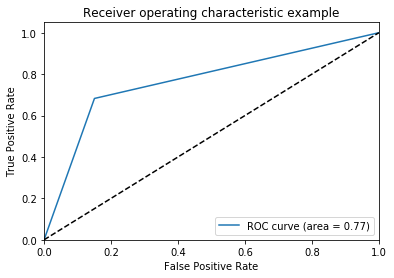

In [25]:
# Plotting the curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [1]:
# Chat box for user input
CRED = '\033[91m'
CEND = '\033[0m'
CGREEN = '\33[32m' 
new_comment=input("Enter Chat: ")
while(new_comment!='exit'):
    X_test=test_data['Comment']
    X_test.set_value(max(X_test.index) + 1,  str(new_comment))#(pd.Series([new_comment]))
    X_test.to_csv('X_test.csv',",",header=['Comment'])
    X_test1=pd.read_csv('X_test.csv')
    X_test1=normalize(X_test1['Comment'])
    X_test1=tf.transform(X_test1)
    X_test1=ch2.transform(X_test1)
    X_test_dense1=X_test1.toarray()
    test_pred1=glm.predict_proba(X_test_dense1)
    test_pred1=test_pred1[:,1]
    final_test_pred1=[]
    for i in range(len(test_pred1)):
        if test_pred1[i]>=0.28:
            final_test_pred1.append(1)
        else:
            final_test_pred1.append(0)
    if test_pred1[-1]>=0.7:
        print(CRED+'Strong abusive content detected. You have been warned.'+CEND)
    if (0.3<=float(test_pred1[-1])<0.7):
        print(CRED+'Insult detected. Kindly mind your words.'+CEND)
    if test_pred1[-1]<=0.3:
        print(CGREEN+"Nicely said! Would like to hear more from you."+CEND)
    print(final_test_pred1[-1],test_pred1[-1])
    new_comment=input("\nEnter Chat: ")

Enter Chat: exit


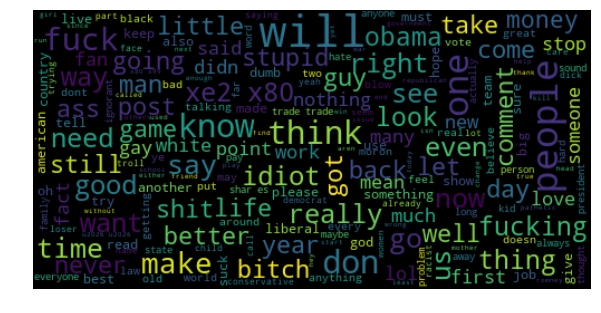

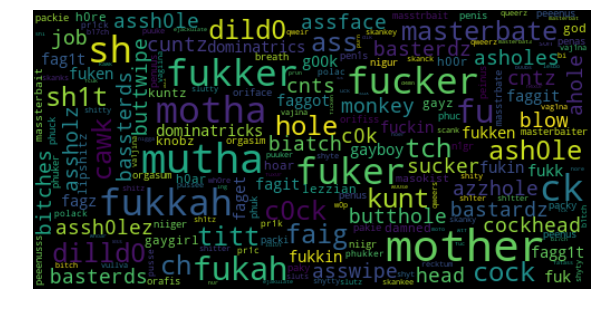

In [28]:
## Word Cloud
# Train Data Comments
text=' '.join(i for i in normalize(train_data['Comment']))

wordcloud = WordCloud(max_font_size=40,width=500,height=250).generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Abusive Word Variants
bwmap=loadBW()
bwmap=' '.join(str(i) for i in bwmap)
wordcloud = WordCloud(max_font_size=40,width=500,height=250).generate(bwmap)
plt.figure(figsize=(10,10))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [130]:
# Analysis for insights
import re
bwmap1=loadBW()
l=p=[]
for i in bwmap1.values():
    l.append(i)

## Real abusive comments count
cnt=tr=0
for i in normalize(train_data['Comment']):
    #print(i)
    tr+=1
    for j in list(set(l)):
        if re.search(j,i):
            cnt+=1
print(cnt,tr)
print((2250-1049)/2250)

## Word Variations
wv_cnt=wv_tr=0
for i in train_data['Comment']:
    #print(i)
    wv_tr+=1
    for j in list(set(l)):
        #print(j)
        if re.search(j,i):
            wv_cnt+=1
print(wv_cnt,wv_tr)

2250 3947
0.5337777777777778
1824 3947
